In [9]:
import os
import joblib
from tqdm import tqdm
from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary
from torchviz import make_dot
import shap
from captum.attr import IntegratedGradients

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## TCN

### Data Importing

In [18]:
df = pd.read_csv("./.data/train_aug.csv")

In [19]:
print(df)

               id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0           p01_0  3.094944  3.205389  3.313624  3.339701  3.361018  3.379836   
1           p01_1  3.340175  3.361399  3.380423  3.339701  3.294160  3.246258   
2           p01_2  3.340175  3.294538  3.246826  3.172513  3.093589  3.012496   
3           p01_3  3.172972  3.093953  3.013033  3.038763  3.060160  3.079285   
4           p01_4  3.039210  3.060522  3.079831  3.061055  3.037874  3.012496   
...           ...       ...       ...       ...       ...       ...       ...   
354043  p12_25294 -0.156654 -0.156741 -0.210417 -0.177942 -0.285088 -0.383573   
354044  p12_25295 -0.153169 -0.205252 -0.177643 -0.291374 -0.403435 -0.453188   
354045  p12_25296 -0.182927 -0.187252 -0.292545 -0.392158 -0.450797 -0.517543   
354046  p12_25297 -0.197369 -0.276990 -0.399657 -0.454536 -0.553658 -0.620565   
354047  p12_25298 -0.285812 -0.385110 -0.459777 -0.539657 -0.641673 -0.682555   

         bg-1:25   bg-1:20 

In [20]:
for col in df.columns:
    print(col)

id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
hr-0:50
hr-0:45
hr-0:40
hr-0:35
hr-0:30
hr-0:25
hr-0:20
hr-0:15
hr-0:10
hr-0:05
hr-0:00
steps-1:55
steps-1:50
steps-1:45
step

### Data Splitting

In [21]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [22]:
print(f"Train Shape: {train_df.shape}")
print(f"Validation Shape: {val_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (283238, 146)
Validation Shape: (35405, 146)
Test Shape: (35405, 146)


In [24]:
# val_df.to_csv("./.data/train_val_aug.csv", index=False)
# test_df.to_csv("./.data/train_test_aug.csv", index=False)

### Dataset and DataLoader

In [25]:
class BrisT1DDataset(Dataset):
    def __init__(self, df, is_train=True):
        self.df = df
        self.is_train = is_train
        
        if 'id' in self.df.columns:
            self.ids = self.df['id'].values
            self.df = self.df.drop(columns=['id'])
        else:
            self.ids = None
        
        if self.is_train and 'bg+1:00' in self.df.columns:
            self.targets = self.df['bg+1:00'].values
            self.df = self.df.drop(columns=['bg+1:00'])
        else:
            self.targets = None
        
        data = self.df.values.astype(np.float32)
        if data.shape[1] != 144:
            raise ValueError(f"Expected 144, Real {data.shape[1]}")

        self.X = data.reshape(-1, 6, 24).transpose(0, 2, 1)
        
        if self.is_train:
            self.y = self.targets.astype(np.float32).reshape(-1, 1)
        else:
            self.y = None

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.is_train:
            target = torch.tensor(self.y[idx], dtype=torch.float32)
            return sample, target
        else:
            return sample

In [26]:
train_dataset = BrisT1DDataset(train_df, is_train=True)
val_dataset = BrisT1DDataset(val_df, is_train=True)
test_dataset = BrisT1DDataset(test_df, is_train=True)

In [27]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [28]:
class BrisT1DChomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
        
    def forward(self, x):
        if self.chomp_size > 0:
            return x[:, :, :-self.chomp_size].contiguous()
        return x

In [29]:
class BrisT1DTemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                            stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = BrisT1DChomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                            stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = BrisT1DChomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

In [30]:
class BrisT1DTCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.25):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            padding = (kernel_size - 1) * dilation_size
            layers.append(BrisT1DTemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                        dilation=dilation_size, padding=padding,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)
        
    def forward(self, x):
        x = x.transpose(1, 2)
        y = self.network(x)
        y = y[:, :, -1]
        out = self.fc(y)
        return out

In [31]:
model = BrisT1DTCN(num_inputs=6, num_channels=[64, 32], kernel_size=2, dropout=0.25).to(device)
print(model)

BrisT1DTCN(
  (network): Sequential(
    (0): BrisT1DTemporalBlock(
      (conv1): Conv1d(6, 64, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp1): BrisT1DChomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.25, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp2): BrisT1DChomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.25, inplace=False)
      (net): Sequential(
        (0): Conv1d(6, 64, kernel_size=(2,), stride=(1,), padding=(1,))
        (1): BrisT1DChomp1d()
        (2): ReLU()
        (3): Dropout(p=0.25, inplace=False)
        (4): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
        (5): BrisT1DChomp1d()
        (6): ReLU()
        (7): Dropout(p=0.25, inplace=False)
      )
      (downsample): Conv1d(6, 64, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): BrisT1DTemporalBlock(
      (conv1): Conv1d(64, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2

#### Model Summary

In [32]:
dummy_seq = torch.randn(1, 24, 6).to(device)

In [33]:
print("Model Summary:")
print(summary(model, input_data=[dummy_seq]))

Model Summary:
Layer (type:depth-idx)                        Output Shape              Param #
BrisT1DTCN                                    [1, 1]                    --
├─Sequential: 1-1                             [1, 32, 24]               --
│    └─BrisT1DTemporalBlock: 2-1              [1, 64, 24]               --
│    │    └─Sequential: 3-1                   [1, 64, 24]               9,088
│    │    └─Conv1d: 3-2                       [1, 64, 24]               448
│    │    └─ReLU: 3-3                         [1, 64, 24]               --
│    └─BrisT1DTemporalBlock: 2-2              [1, 32, 24]               --
│    │    └─Sequential: 3-4                   [1, 32, 24]               6,208
│    │    └─Conv1d: 3-5                       [1, 32, 24]               2,080
│    │    └─ReLU: 3-6                         [1, 32, 24]               --
├─Linear: 1-2                                 [1, 1]                    33
Total params: 17,857
Trainable params: 17,857
Non-trainable params: 0


#### Model Computational Graph

In [34]:
dummy_output = model(dummy_seq)
dot = make_dot(dummy_output, params=dict(model.named_parameters()))

Model Computational Graph:


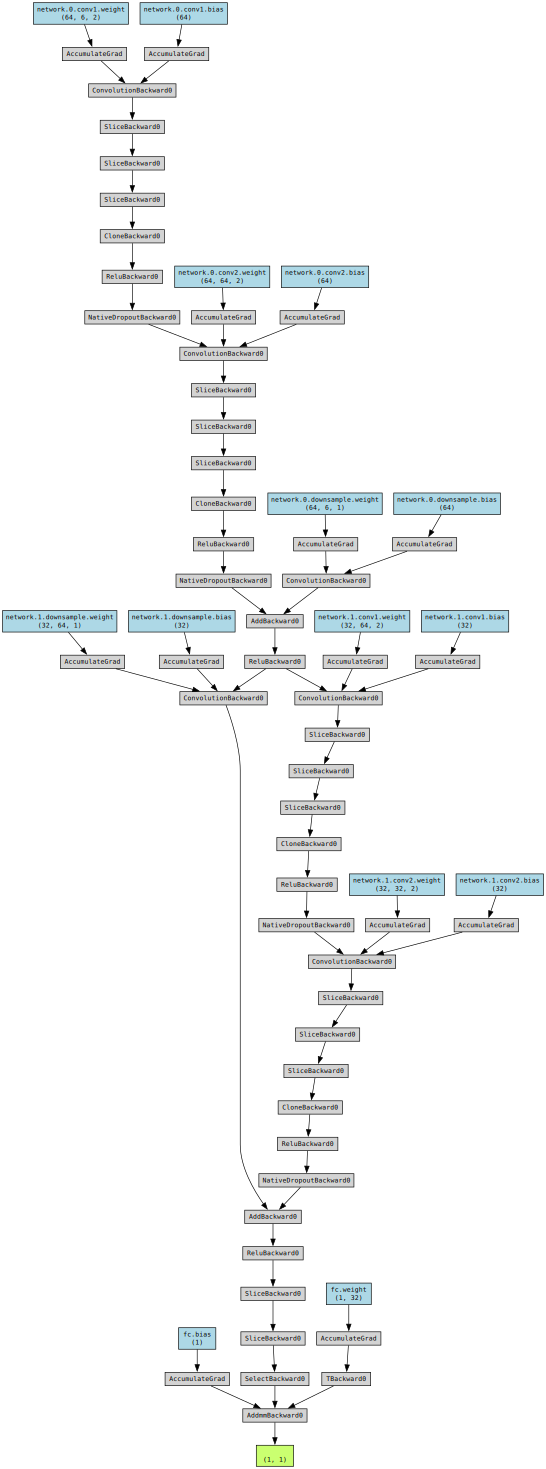

In [35]:
print("Model Computational Graph:")
display(dot)

### Training

In [36]:
epochs = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
patience = 10

In [37]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_no_improve = 0

In [38]:
for epoch in range(epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False):
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            running_val_loss += loss.item() * X_val.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), './.export/checkpoint-aug-tcn.pt')
    else:
        epochs_no_improve += 1
        print(f"Early Stopping: {epochs_no_improve}/{patience}")
        
    if epochs_no_improve >= patience:
        print("Early Stopping!")
        break

Epoch 1/100 [Training]:   0%|          | 0/2213 [00:00<?, ?it/s]

Epoch: 1/100 | Train Loss: 0.4793 | Val Loss: 0.4622


Epoch: 2/100 | Train Loss: 0.4580 | Val Loss: 0.4519


Epoch: 3/100 | Train Loss: 0.4521 | Val Loss: 0.4449


Epoch: 4/100 | Train Loss: 0.4486 | Val Loss: 0.4417


Epoch: 5/100 | Train Loss: 0.4448 | Val Loss: 0.4391


Epoch: 6/100 | Train Loss: 0.4417 | Val Loss: 0.4347


Epoch: 7/100 | Train Loss: 0.4395 | Val Loss: 0.4334


Epoch: 8/100 | Train Loss: 0.4374 | Val Loss: 0.4317


Epoch: 9/100 | Train Loss: 0.4359 | Val Loss: 0.4301


Epoch: 10/100 | Train Loss: 0.4347 | Val Loss: 0.4291


Epoch: 11/100 | Train Loss: 0.4331 | Val Loss: 0.4307
Early Stopping: 1/10


Epoch: 12/100 | Train Loss: 0.4321 | Val Loss: 0.4321
Early Stopping: 2/10


Epoch: 13/100 | Train Loss: 0.4312 | Val Loss: 0.4277


Epoch: 14/100 | Train Loss: 0.4301 | Val Loss: 0.4258


Epoch: 15/100 | Train Loss: 0.4294 | Val Loss: 0.4243


Epoch: 16/100 | Train Loss: 0.4286 | Val Loss: 0.4225


Epoch: 17/100 | Train Loss: 0.4278 | Val Loss: 0.4246
Early Stopping: 1/10


Epoch: 18/100 | Train Loss: 0.4270 | Val Loss: 0.4205


Epoch: 19/100 | Train Loss: 0.4264 | Val Loss: 0.4213
Early Stopping: 1/10


Epoch: 20/100 | Train Loss: 0.4250 | Val Loss: 0.4189


Epoch: 21/100 | Train Loss: 0.4248 | Val Loss: 0.4192
Early Stopping: 1/10


Epoch: 22/100 | Train Loss: 0.4245 | Val Loss: 0.4190
Early Stopping: 2/10


Epoch: 23/100 | Train Loss: 0.4235 | Val Loss: 0.4201
Early Stopping: 3/10


Epoch: 24/100 | Train Loss: 0.4228 | Val Loss: 0.4193
Early Stopping: 4/10


Epoch: 25/100 | Train Loss: 0.4220 | Val Loss: 0.4186


Epoch: 26/100 | Train Loss: 0.4215 | Val Loss: 0.4188
Early Stopping: 1/10


Epoch: 27/100 | Train Loss: 0.4212 | Val Loss: 0.4189
Early Stopping: 2/10


Epoch: 28/100 | Train Loss: 0.4206 | Val Loss: 0.4143


Epoch: 29/100 | Train Loss: 0.4202 | Val Loss: 0.4172
Early Stopping: 1/10


Epoch: 30/100 | Train Loss: 0.4199 | Val Loss: 0.4141


Epoch: 31/100 | Train Loss: 0.4190 | Val Loss: 0.4150
Early Stopping: 1/10


Epoch: 32/100 | Train Loss: 0.4186 | Val Loss: 0.4146
Early Stopping: 2/10


Epoch: 33/100 | Train Loss: 0.4188 | Val Loss: 0.4173
Early Stopping: 3/10


Epoch: 34/100 | Train Loss: 0.4173 | Val Loss: 0.4168
Early Stopping: 4/10


Epoch: 35/100 | Train Loss: 0.4169 | Val Loss: 0.4150
Early Stopping: 5/10


Epoch: 36/100 | Train Loss: 0.4168 | Val Loss: 0.4139


Epoch: 37/100 | Train Loss: 0.4169 | Val Loss: 0.4119


Epoch: 38/100 | Train Loss: 0.4171 | Val Loss: 0.4133
Early Stopping: 1/10


Epoch: 39/100 | Train Loss: 0.4162 | Val Loss: 0.4131
Early Stopping: 2/10


Epoch: 40/100 | Train Loss: 0.4163 | Val Loss: 0.4132
Early Stopping: 3/10


Epoch: 41/100 | Train Loss: 0.4158 | Val Loss: 0.4128
Early Stopping: 4/10


Epoch: 42/100 | Train Loss: 0.4155 | Val Loss: 0.4133
Early Stopping: 5/10


Epoch: 43/100 | Train Loss: 0.4148 | Val Loss: 0.4163
Early Stopping: 6/10


Epoch: 44/100 | Train Loss: 0.4149 | Val Loss: 0.4115


Epoch: 45/100 | Train Loss: 0.4149 | Val Loss: 0.4135
Early Stopping: 1/10


Epoch: 46/100 | Train Loss: 0.4139 | Val Loss: 0.4096


Epoch: 47/100 | Train Loss: 0.4136 | Val Loss: 0.4107
Early Stopping: 1/10


Epoch: 48/100 | Train Loss: 0.4142 | Val Loss: 0.4116
Early Stopping: 2/10


Epoch: 49/100 | Train Loss: 0.4129 | Val Loss: 0.4127
Early Stopping: 3/10


Epoch: 50/100 | Train Loss: 0.4127 | Val Loss: 0.4128
Early Stopping: 4/10


Epoch: 51/100 | Train Loss: 0.4132 | Val Loss: 0.4088


Epoch: 52/100 | Train Loss: 0.4125 | Val Loss: 0.4078


Epoch: 53/100 | Train Loss: 0.4120 | Val Loss: 0.4125
Early Stopping: 1/10


Epoch: 54/100 | Train Loss: 0.4125 | Val Loss: 0.4117
Early Stopping: 2/10


Epoch: 55/100 | Train Loss: 0.4119 | Val Loss: 0.4095
Early Stopping: 3/10


Epoch: 56/100 | Train Loss: 0.4120 | Val Loss: 0.4093
Early Stopping: 4/10


Epoch: 57/100 | Train Loss: 0.4119 | Val Loss: 0.4121
Early Stopping: 5/10


Epoch: 58/100 | Train Loss: 0.4110 | Val Loss: 0.4074


Epoch: 59/100 | Train Loss: 0.4108 | Val Loss: 0.4103
Early Stopping: 1/10


Epoch: 60/100 | Train Loss: 0.4105 | Val Loss: 0.4090
Early Stopping: 2/10


Epoch: 61/100 | Train Loss: 0.4103 | Val Loss: 0.4111
Early Stopping: 3/10


Epoch: 62/100 | Train Loss: 0.4103 | Val Loss: 0.4082
Early Stopping: 4/10


Epoch: 63/100 | Train Loss: 0.4101 | Val Loss: 0.4079
Early Stopping: 5/10


Epoch: 64/100 | Train Loss: 0.4104 | Val Loss: 0.4070


Epoch: 65/100 | Train Loss: 0.4093 | Val Loss: 0.4076
Early Stopping: 1/10


Epoch: 66/100 | Train Loss: 0.4098 | Val Loss: 0.4125
Early Stopping: 2/10


Epoch: 67/100 | Train Loss: 0.4092 | Val Loss: 0.4084
Early Stopping: 3/10


Epoch: 68/100 | Train Loss: 0.4094 | Val Loss: 0.4070
Early Stopping: 4/10


Epoch: 69/100 | Train Loss: 0.4086 | Val Loss: 0.4110
Early Stopping: 5/10


Epoch: 70/100 | Train Loss: 0.4083 | Val Loss: 0.4058


Epoch: 71/100 | Train Loss: 0.4084 | Val Loss: 0.4093
Early Stopping: 1/10


Epoch: 72/100 | Train Loss: 0.4089 | Val Loss: 0.4075
Early Stopping: 2/10


Epoch: 73/100 | Train Loss: 0.4081 | Val Loss: 0.4089
Early Stopping: 3/10


Epoch: 74/100 | Train Loss: 0.4078 | Val Loss: 0.4103
Early Stopping: 4/10


Epoch: 75/100 | Train Loss: 0.4080 | Val Loss: 0.4042


Epoch: 76/100 | Train Loss: 0.4080 | Val Loss: 0.4051
Early Stopping: 1/10


Epoch: 77/100 | Train Loss: 0.4076 | Val Loss: 0.4126
Early Stopping: 2/10


Epoch: 78/100 | Train Loss: 0.4078 | Val Loss: 0.4062
Early Stopping: 3/10


Epoch: 79/100 | Train Loss: 0.4069 | Val Loss: 0.4077
Early Stopping: 4/10


Epoch: 80/100 | Train Loss: 0.4066 | Val Loss: 0.4052
Early Stopping: 5/10


Epoch: 81/100 | Train Loss: 0.4068 | Val Loss: 0.4052
Early Stopping: 6/10


Epoch: 82/100 | Train Loss: 0.4069 | Val Loss: 0.4074
Early Stopping: 7/10


Epoch: 83/100 | Train Loss: 0.4070 | Val Loss: 0.4044
Early Stopping: 8/10


Epoch: 84/100 | Train Loss: 0.4073 | Val Loss: 0.4061
Early Stopping: 9/10


Epoch: 85/100 | Train Loss: 0.4066 | Val Loss: 0.4043
Early Stopping: 10/10
Early Stopping!


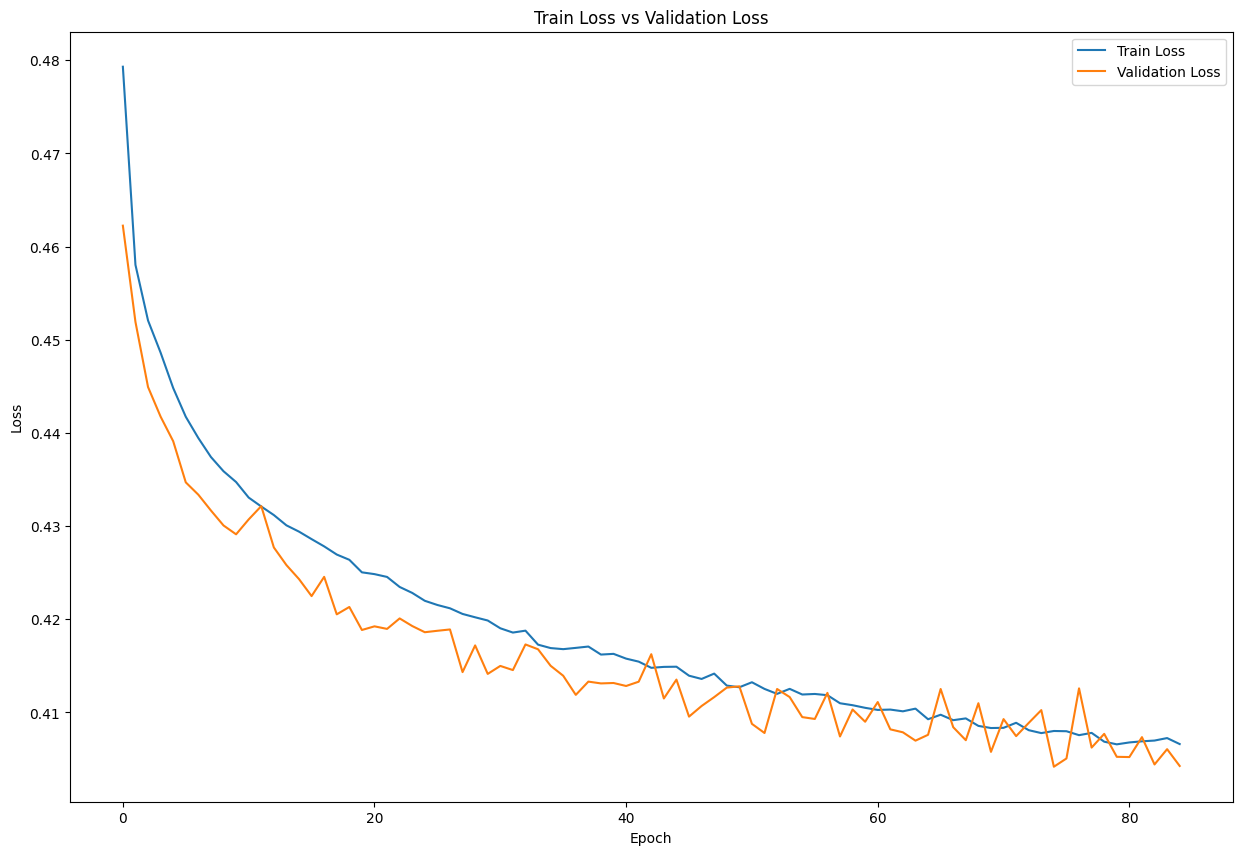

In [39]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.show()

### Evaluation

In [40]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-tcn.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27944\2496434295.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-tc

<All keys matched successfully>

In [41]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target)**2))

def mae(pred, target):
    return np.mean(np.abs(pred - target))

def mard(pred, target):
    return np.mean(np.abs(pred - target) / (np.abs(target) + 1e-6))

def mbe(pred, target):
    return np.mean(pred - target)

def mape(pred, target):
    return np.mean(np.abs((target - pred) / (target + 1e-6))) * 100

def pearson_r(pred, target):
    return np.corrcoef(pred, target)[0, 1]

def ccc(pred, target):
    pred_mean = np.mean(pred)
    target_mean = np.mean(target)
    pred_var = np.var(pred)
    target_var = np.var(target)
    covariance = np.mean((pred - pred_mean) * (target - target_mean))
    return (2 * covariance) / (pred_var + target_var + (pred_mean - target_mean)**2 + 1e-6)

In [42]:
model.eval()
preds = []
preds_targets = []

with torch.no_grad():
    for x_seq, targets in tqdm(test_loader, desc="Evaluation"):
        x_seq = x_seq.to(device)
        targets = targets.to(device)
        outputs = model(x_seq)
        preds.append(outputs.cpu().numpy())
        preds_targets.append(targets.cpu().numpy())
        
preds = np.concatenate(preds)
preds_targets = np.concatenate(preds_targets)

Evaluation: 100%|██████████| 277/277 [00:01<00:00, 187.80it/s]


In [43]:
target_scaler = joblib.load('./.data/target_scaler_aug.pkl')
all_preds = target_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
all_targets = target_scaler.inverse_transform(preds_targets.reshape(-1, 1)).flatten()

In [44]:
calibration_model = LinearRegression()
calibration_model.fit(all_preds.reshape(-1, 1), all_targets)
calibrated_val_preds = calibration_model.predict(all_preds.reshape(-1, 1))

all_preds = calibrated_val_preds

In [45]:
residuals = all_preds - all_targets

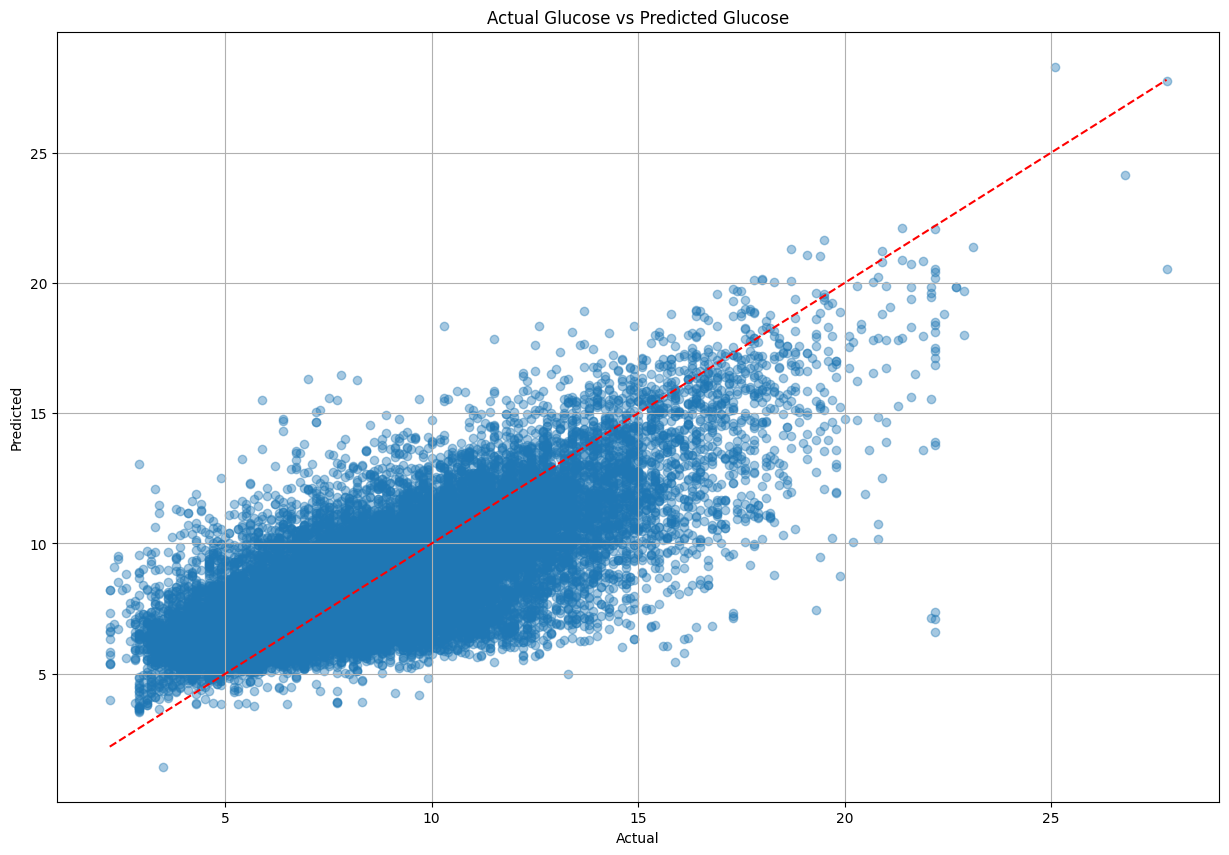

In [46]:
plt.figure(figsize=(15, 10))
plt.scatter(all_targets, all_preds, alpha=0.4)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual Glucose vs Predicted Glucose")
plt.grid(True)
plt.show()

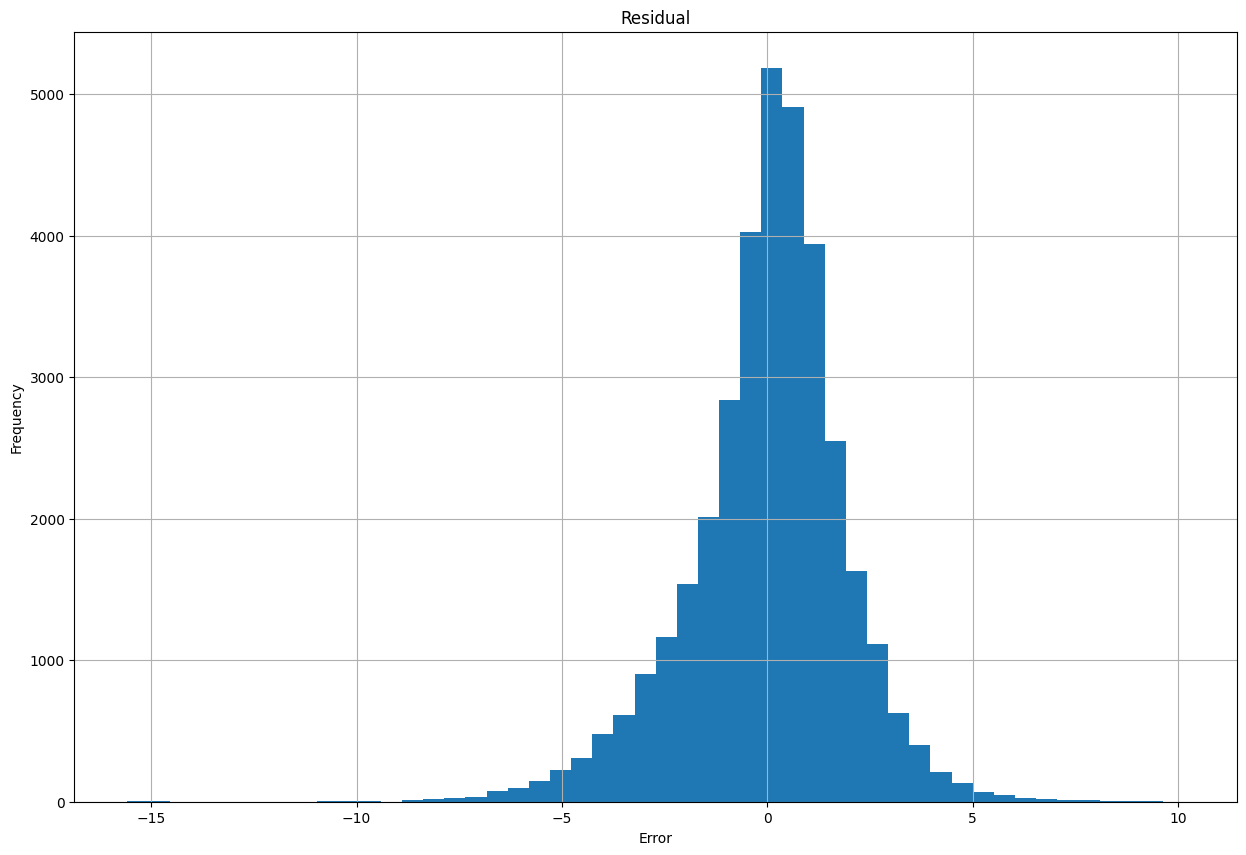

In [47]:
plt.figure(figsize=(15, 10))
plt.hist(residuals, bins=50)
plt.title("Residual")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [48]:
from sklearn.metrics import r2_score
test_r2 = r2_score(all_targets, all_preds)

In [49]:
from sklearn.metrics import explained_variance_score
test_expl_var = explained_variance_score(all_targets, all_preds)

In [50]:
test_rmse = rmse(all_preds, all_targets)
test_mae = mae(all_preds, all_targets)
test_mard = mard(all_preds, all_targets)

test_mbe = mbe(all_preds, all_targets)
test_r2 = r2_score(all_targets, all_preds)
test_expl_var = explained_variance_score(all_targets, all_preds)
test_mape = mape(all_preds, all_targets)
test_ccc = ccc(all_preds, all_targets)

In [51]:
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MSE: {test_rmse**2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MARD: {test_mard:.4f}")
print(f"Test MBE: {test_mbe:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Explained Variance: {test_expl_var:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test CCC: {test_ccc:.4f}")

Test RMSE: 1.9109
Test MSE: 3.6514
Test MAE: 1.4092
Test MARD: 0.1874
Test MBE: -0.0000
Test R²: 0.5887
Test Explained Variance: 0.5887
Test MAPE: 18.74%
Test CCC: 0.7411


### Explanation

In [52]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-tcn.pt'))
model.eval()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27944\283940974.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-tcn

BrisT1DTCN(
  (network): Sequential(
    (0): BrisT1DTemporalBlock(
      (conv1): Conv1d(6, 64, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp1): BrisT1DChomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.25, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp2): BrisT1DChomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.25, inplace=False)
      (net): Sequential(
        (0): Conv1d(6, 64, kernel_size=(2,), stride=(1,), padding=(1,))
        (1): BrisT1DChomp1d()
        (2): ReLU()
        (3): Dropout(p=0.25, inplace=False)
        (4): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
        (5): BrisT1DChomp1d()
        (6): ReLU()
        (7): Dropout(p=0.25, inplace=False)
      )
      (downsample): Conv1d(6, 64, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): BrisT1DTemporalBlock(
      (conv1): Conv1d(64, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2

In [53]:
sensor_names = ["bg (Blood Glucose Reading)", 
                "insulin (Insulin Intake)", 
                "carbs (Carbohydrate Intake)", 
                "hr (Mean Heart Rate)", 
                "steps (Steps Walked)", 
                "cals (Calories Burned)"]

In [54]:
def avg_ig_values(model, test_loader=test_loader, n_samples=None):
    ig = IntegratedGradients(model)

    total_samples = sum(x.shape[0] for x, _ in test_loader)
    
    if n_samples is None:
        n_samples = total_samples // 2

    attr_accum = torch.zeros((24, 6), device=device)
    delta_list = []
    
    sampled = 0
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        
        for i in range(x_batch.shape[0]):
            if sampled >= n_samples:
                break
            input_seq = x_batch[i:i+1]
            
            attr, delta = ig.attribute(
                input_seq,
                baselines=torch.zeros_like(input_seq),
                return_convergence_delta=True
            )
            
            attr_accum += attr.squeeze(0)
            delta_list.append(delta.item())
            sampled += 1
        
        if sampled >= n_samples:
            break

    avg_attr = attr_accum / n_samples
    avg_attr = avg_attr.detach().cpu().numpy()
    
    return n_samples, avg_attr, delta_list


In [55]:
n_samples, avg_attr, delta_list = avg_ig_values(model, test_loader=test_loader)

In [56]:
print(f"Average Convergence Delta: {np.mean(delta_list):.6f}")

Average Convergence Delta: 0.000181


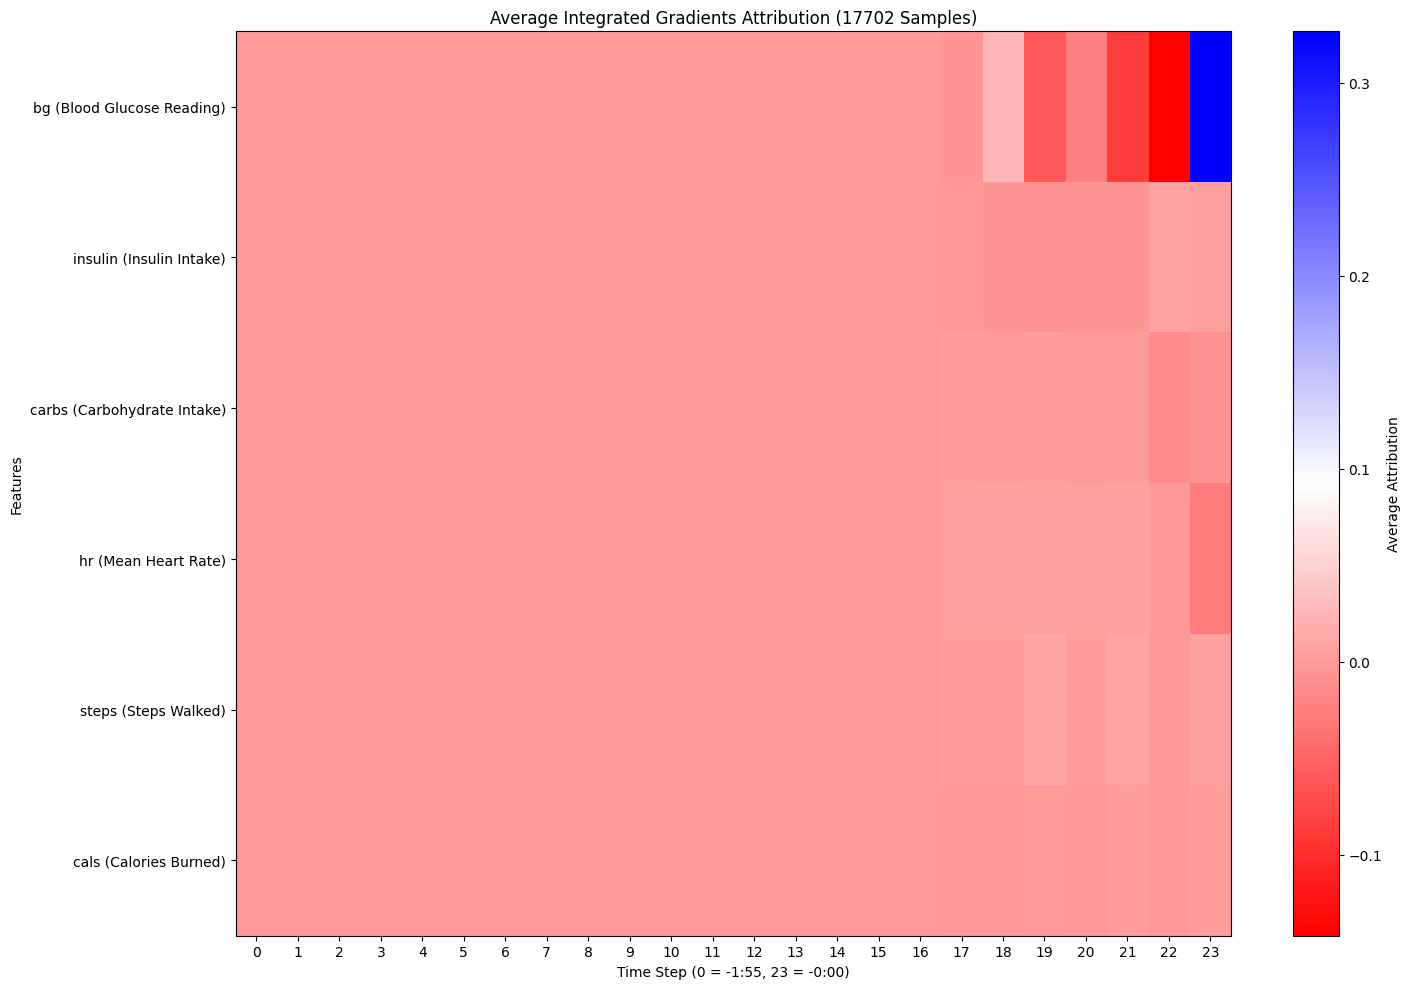

In [57]:
plt.figure(figsize=(15, 10))
plt.imshow(avg_attr.T, aspect='auto', cmap='bwr_r', interpolation='nearest')
plt.colorbar(label='Average Attribution')
plt.xlabel("Time Step (0 = -1:55, 23 = -0:00)")
plt.ylabel("Features")
plt.title(f"Average Integrated Gradients Attribution ({n_samples} Samples)")
plt.xticks(range(24))
plt.yticks(range(6), sensor_names)
plt.grid(False)
plt.tight_layout()
plt.show()

### Inference

In [58]:
df_test = pd.read_csv("./.data/test_aug.csv")

In [59]:
print(df_test)

            id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0     p01_8459  1.498370  1.484493  1.503679  1.531703  1.553799  1.622914   
1     p01_8460 -0.486487 -0.648439 -0.811465 -0.926369 -1.035974 -1.140981   
2     p01_8461 -1.101087 -1.091123 -1.083243 -1.078102 -1.066323 -1.050196   
3     p01_8462 -1.564556 -1.609264 -1.656996 -1.624340 -1.582254 -1.534382   
4     p01_8463 -1.443651 -1.533807 -1.626799 -1.664802 -1.693533 -1.715952   
...        ...       ...       ...       ...       ...       ...       ...   
3639   p24_256 -0.748448 -0.598134 -0.509490 -0.481286 -0.600973 -0.535748   
3640   p24_257 -0.839126 -0.598134 -0.388700 -0.329553 -0.297484 -0.354179   
3641   p24_258  0.339697  0.337539  0.305844  0.277379  0.218447  0.220792   
3642   p24_259 -0.476411 -0.477402 -0.479292 -0.450939 -0.388531 -0.354179   
3643   p24_260 -0.929805 -0.960330 -0.871860 -0.875791 -0.843764 -0.747580   

       bg-1:25   bg-1:20   bg-1:15  ...  cals-0:45  cals-0:40  

In [60]:
for col in df_test.columns:
    print(col)

id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
hr-0:50
hr-0:45
hr-0:40
hr-0:35
hr-0:30
hr-0:25
hr-0:20
hr-0:15
hr-0:10
hr-0:05
hr-0:00
steps-1:55
steps-1:50
steps-1:45
step

In [61]:
meta_data = ['id']
df_test_meta = df_test[meta_data]
df_test.drop(columns=meta_data, inplace=True)

In [62]:
infer_test_dataset = BrisT1DDataset(df_test, is_train=False)
infer_test_loader = DataLoader(infer_test_dataset, batch_size=256, shuffle=False)

In [63]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-tcn.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27944\2496434295.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-tc

<All keys matched successfully>

In [64]:
model.eval()

all_preds = []
with torch.no_grad():
    for x_seq in tqdm(infer_test_loader, desc="Inference"):
        x_seq = x_seq.to(device)
        outputs = model(x_seq)
        all_preds.append(outputs.cpu().numpy())

all_preds = np.concatenate(all_preds)

Inference: 100%|██████████| 15/15 [00:00<00:00, 102.28it/s]


In [65]:
target_scaler = joblib.load('./.data/target_scaler_aug.pkl')
all_preds_original = target_scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()

In [66]:
calibrated_test_preds = calibration_model.predict(all_preds_original.reshape(-1, 1))
all_preds_original = calibrated_test_preds

In [67]:
df_predictions = pd.DataFrame(all_preds_original, columns=["bg+1:00"])
df_results = pd.concat([df_test_meta.reset_index(drop=True), df_predictions], axis=1)
df_results.to_csv("./.export/test_submission_aug_tcn.csv", index=False)

### Submission

In [68]:
!kaggle competitions submit -c brist1d -f ./.export/test_submission_aug_tcn.csv -m "BrisT1D Submission: TCN (Calibrated)"

Successfully submitted to BrisT1D Blood Glucose Prediction Competition



  0%|          | 0.00/67.8k [00:00<?, ?B/s]
100%|██████████| 67.8k/67.8k [00:00<00:00, 76.9kB/s]


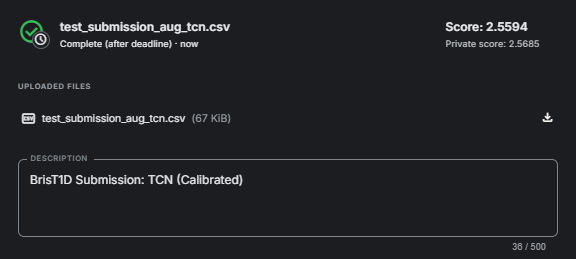

In [69]:
display(Image(filename='./.export/test_submission_aug_tcn.png'))